<h1 align="center">Authorship Attribution using Machine Learning
</h1>       

<img src="images/title.png" height="233" width="500">

### Overview and Motivation

The objective of this project is to investigate application of Machine Learning algorithms for authorship attribution. Authorship attribution refers to the process of identifying the writer of a piece of text.
It has a wide range of applications in many diverse domains such as :
- Academia
- History of Literature
- Homeland Security
- Criminal Investigation

The basic idea behind Authorship Attribution is to analyse text document such as a letter, book, transcript of telephonic conversation, email or social media post under pseudonym to find the author.

Some typical applications are plagiarism detection, finding the author of an anonymously published literary work, identifying an individual terrorist or a terrorist organisation from their written letters or threat emails and shortlisting potential criminals.

The main goal of the project is to develop a model to detect the author/writer of a piece of text from a list of authors/writers given a piece of text.

I have divided the project into following phases:

1) Discovery 

2) Data Preparation

3) Model Planning

4) Model Building

5) Result

6) Operational Implementation


### 1. Discovery

In this phase I consulted a number of research papers, online resources and  some books to learn how other data scientists have addressed authorship attribution problem. The references are given at the end of this notebook.


#### 1.1 Authorship Attribution Overview


Authorship attribution employs stylometry for finding the author of a piece of text. Stylometry can be defined as  the study of linguistic style of written text. It involves identifying unique style markers in a given piece of text.The style markers are those features that one can find repeating in different texts writtern by the same writer.This repeating style markers are called 'writer invariant'.

Stylometry analysis uses lexical, synctactic, structural and content specific style markers that distinguish an author from other authors. Lexical descriptors provide statistics such as total number of words/characters, average number of words per sentence and distribution of word length etc.Synctactic features focus on structure of the sentences such as usage of punctuation marks whereas the structural markers look into the organisation of text into paragraphs, headings etc[1].

Some approaches take into account n-grams (combination of words) as features while others only use set of terms called 'bag of words' approach.


#### 1.2 Related Work 

Different researchers have tried different machine learning algorithms for authorship attribution. Some of the main algorithms that I found in the papers that I consulted include K-nearest neighbors, Bayesian, Support Vector Machines(SVM), Feed Forward Multilayer Perceptrons (MLP) and ensembles using combination of these algorithms.

In 2007 Bozkurt, Bağlıoğlu and Uyar[2] found that 'Bag of Words' approach with SVM gave very high accuracy. In 2007 Stańczyk and Cyran[1] used ANN and found that highest classification ratio is granted by the exploitation of syntactic textual features.

In 2014 Pratanwanich and Lio[3] have used Supervised Author Topic (SAT) model that is based on probabilistic generative model and has exhibited same performance as Random Forests. 



#### 1.3. Initial Questions & Context

The main questions for this project were:

_1) Can "Bag of Words" as features give acceptable classification accuracy?_

_2) Which algorithms perform best with Bag of Words?_

_3) How can Big Data processing engines such as Apache Spark aid in preparing data for Machine Learning algorithms?_

_4) How can one clean Gutenberg data to be used for different NLP related research projects?_

_5) Can AWS EMR be used as a viable cloud based Big Data platform_?


### 2. Data Preparation

This phase was more data engineering than data preparation as it included writing configuration & bootstrap scripts for AWS EMR, building conda packages for the python libraries that were not available in default conda repositories such as Gutenberg library. 

The main source of data for this project was Gutenberg site with public domain eBooks in the text format.

#### 2.1 Project Gutenberg

Project Gutenberg (http://www.gutenberg.org) at the time of this project offers more than 50,000 eBooks in different languages available for download in different file formats.This project however is focused on books written in English and in plain text form. The first challenge therefore was to identify and download all the books written in English in plain text form.

Project Gutenberg website clearly states on the main page that :

_**The Project Gutenberg website is for human users only. Any real or perceived use of automated tools to access our site will result in a block of your IP address**_

#### 2.2 Robot Site Access


On more investigation I found some information on Gutenberg website on how to download data as via robot at the following URL.

http://www.gutenberg.org/wiki/Gutenberg%3aInformation_About_Robot_Access_to_our_Pages

The information given on this page allows wget based data access by using the following command.

**wget -w 2 -m -H "http://www.gutenberg.org/robot/harvest?filetypes[]=html"**

I created a bash shell script and used it to download the data on my local machine however on executing this script I got following error.



_Resolving www.gutenberg.org (www.gutenberg.org)... 152.19.134.47_

_Connecting to www.gutenberg.org (www.gutenberg.org)|152.19.134.47|:80... connected._

_HTTP request sent, awaiting response... 403 Forbidden_

I searched online if others have come across the same problem and found a number of different sites listing that many other users have come across the same problem. I also tried some of the suggestions but none of them worked.

My next instinct was to mirror the project and then host it behind a local version of Apache Webserver and use BeautifulSoup4 or wget to retrieve the data. The Gutenberg website has provided a rsync based method to clone the whole site http://www.gutenberg.org/wiki/Gutenberg:Mirroring_How-To.

I used the following command to download the main collection.

**rsync -av --del ftp@ftp.ibiblio.org::gutenberg gutenberglocal**

where gutenberglocal  is the directory created to hold all the site content. This worked fine but could only download 25GB of 650GB in one day due slow network connection which meant finding another way to download the data fortunately http://pgiso.pglaf.org/ provides a way to download the data.

The site requires range of eText numbers to be entered in a form before it can create an ISO image to be downloaded.

I therefore first wrote a script to read catalog in MARC format to find all books available in English language.

_The following import section is common for the whole notebook._

In [385]:
%matplotlib inline
import sys
import re
import os
import csv
import codecs
import string
import json
import boto
import pattern
import pandas as pd
import seaborn as sns
import numpy as np
import scipy as sp
import nltk as nl
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from bs4 import BeautifulSoup
from pymarc import MARCReader
from gutenberg.cleanup import strip_headers
from nltk.tokenize import word_tokenize
from boto.s3.key import Key
from pyspark.sql import SQLContext
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from Levenshtein._levenshtein import distance
from sklearn.grid_search import GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.cross_validation import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import classification_report
from sklearn import svm

In [386]:
#Configure Pandas and Seaborne
sns.set_style("whitegrid")
sns.set_context("poster")
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
mpl.style.use('ggplot')
#pd.options.display.mpl_style = 'default' 

#### 2.3 Machine Readable Catalog Reader

Gutenberg website also maintains catalogs in machine readable formats that can be used to create a database of the books available via the project. The catalogs are available at the following URL http://gutenberg.pglaf.org/cache/generated/feeds/

in Resource Description Format(RDF) and MARC 21 formats. MARC 21 format is a machine readable format for communicating bibliographic and related information. I used the catalog.marc.bz2 file downloaded from aforementioned website and **pymarc** (Library to read MARC 21 files) to create a script that takes catalog.marc file as input to create marcs.csv file and also prints out the eText range for Gutenberg files. In order to write this script one needs to understand the fields in MARC 21. I studied the format given at http://www.loc.gov/marc/.
The source code is as given under:

In [387]:
#Language of interest
LANGUAGE = "eng"
#Constants for MARC File format
LANGUAGE_RECORD_FIELD = '008'
URI_RECORD_FIELD = '856'
LANGUAGE_CODE_START_INDEX = 41
LANGUAGE_CODE_END_INDEX = 44


#Function : clean_metadata
#Purpose : Function to clean metadata records
#          Removes special characeters
def clean_metadata(raw):
    if raw is not None:
        pattern = '[^a-zA-Z0-9 ]'
        prog = re.compile(pattern)
        cleaned = prog.sub('', raw)
        return cleaned
 

#Function : get_metadata
#Purpose : Function to retrieve metadata from MARC record
def get_metadata(record):
    #Get language :MARC Code 008        
    language_record = str(record[LANGUAGE_RECORD_FIELD])
    if language_record is not None:
        if len(language_record) > LANGUAGE_CODE_END_INDEX:
            language_code = language_record[LANGUAGE_CODE_START_INDEX:LANGUAGE_CODE_END_INDEX]
            #Only proceed if language is language of interest
            if(language_code == LANGUAGE):
                #Find URI to access file: MARC Code 856
                url = str(record[URI_RECORD_FIELD]['u'])
                title = record.title()
                if title is None:
                    title = "Unknown"
                author = record.author()
                if author is None:
                    author = "Unknown"
                title = clean_metadata(title.encode('utf-8'))
                author = clean_metadata(author.encode('utf-8'))
                return (title,author,url)

#Function : get_etext_number
#Purpose : Given metadata, retrieves the eText number of the book
def get_etext_number(metadata):
    if metadata is not None:
        url = metadata[2]
        filename = url[url.rindex('/')+1:]
        return filename 
 

etexts = []
#Remove previous marcs.csv if it exists
if os.path.exists('marcs.csv'):
    os.remove('marcs.csv')
with open('marcs.csv', 'wb') as csvfile:
    filewriter = csv.writer(csvfile)
    with open('data/catalog.marc','r') as fh:
        reader = MARCReader(fh)
        for record in reader:
            #Get metadata for the book
            metadata = get_metadata(record)
            if metadata is not None:
                filewriter.writerow([metadata[1],metadata[0],metadata[2]])
            etext = get_etext_number(metadata)
            if etext is not None:
                etexts.append(int(etext))       

print "Minimum eText is:"+ str(min(etexts))
print "Mazimum eText is:"+ str(max(etexts))


Minimum eText is:1
Mazimum eText is:45398


The marcs.csv file generated by reading catalog in MARCS format allows one to get to any book by any author using a web browser. Theoretically this database can be fed into a python script using urllib and urllib2 modules to download this data on the local filesystem. However when I tried to download the files using this urllib script this was refused by the Gutenberg website as well. It makes sense as it is a portal being maintained by donations on a limited resource infrastructure so bots accessing it frequently will put unwarranted load on Gutenberg server/servers.    

#### 2.4 Project Gutenberg Custom ISO Creator

Project Gutenberg Custom ISO Creator is a beta project at the time of this project and can be accessed at 
http://pgiso.pglaf.org/.

It basically takes a user query and generates an ISO file to be burnt on DVD with files meeting that query. We can use the eText range obtained by MARC catalog reader script given in the previous step to form my query for downloading the English language books in text format. This is likely to include all English books written until 2014 as that's when the MARCS 21 file for gutenberg was last modified.

<img src="images/pglaf_website.jpg" height="233" width="500">

When **Add These ETexts** button is pressed followed by **Create ISO** button the next screen prompts to give user email address.We used a **Single-page index file** option. Once the ISO is prepared an email is dispatched by the system to the email address given by the user. This email contains the link to the ISO created by the system.


#### 2.5 ISO to AWS S3

Next I launched an EMR cluster on AWS and used wget to download the data from link received in email from pgiso system of Project Gutenberg. I also created S3 bucket to store all the raw data and data generated from modelling and analysis steps. In order to copy raw data I configured **awscli** on local machine.

The script to create AWS EMR and the associated configuration file (script/spark-conf.json) is available in the script subdirectory of the project. The _install-anaconda_ script needs to be copied to the S3 bucket and the name of the S3 bucket should be added in the _create-emr-cluster script_ available in the scripts directory.

Once the cluster is launched one can find the public DNS name of the master node and ssh into the master to download the data.

On EC2 shell of the master  I used:

**wget -c -O Englishbooks.iso "link received in pgiso email"**

Now one can mount this image and copy the data to S3 bucket using the following commands.

1. sudo mkdir -p /mnt/disk
2. mount -o loop EnglishBooks.iso /mnt/disk
3. cd /mnt/disk/cache
4. aws s3 cp generated s3://cs109-gutenberg/raw --recursive

These aforementioned steps copied all the data to s3 bucket named cs109-gutenberg.The ISO image created by Gutenberg also contains an **index.htm** file with list of all files. If opened in browser the structure of the index




<img src="images/pglaf_index_file.jpg" >

This is semistructured html data that I needed to convert into a structured CSV format. I wrote the following python utility script to convert index.htm to csv file. 

#### 2.6 Index.htm to CSV

Please note that complete script is given in scripts/pgindextocsv.py and accepts the base url as input argument. Base URL should be the DNS based name of S3 bucket. The code below is extracted from pgindextocsv to demonstrate the creation of CSV file containing information about books and authors.

Since we copied the files in raw folder on S3 we should use the pgindextocsv as follows on shell:

**./pgindextocsv.py ../data/index.htm raw**

This will create the correct URLs in pgindex.csv for files in the S3 bucket.

In [388]:
#Utility script to convert Gutenberg data index file to CSV
#Gutenberg data when downloaded from pgiso.pglaf.org comes with
#index file containing metadata about downloaded eBooks
#This utility script converts that metadata into CSV format

#Function : get_book_name
#Purpose : Retrieves book name from the raw text
def get_book_name(raw):
    if raw is not None:
        pattern = '[^a-zA-Z0-9_ ]'
        prog = re.compile(pattern)
        raw = prog.sub('', raw)
        return raw
    else:
        return "Unknown"

#Function : get_author_name
#Purpose : Retrieves author's first and last name from the raw text
def get_author_name(raw):
    if raw is not None:
        raw = raw.replace(';',',')
        pattern = '[^a-zA-Z, ]'
        prog = re.compile(pattern)
        raw = prog.sub('',raw)
        raw = raw.strip()
        names = raw.strip(',')
        names = names.split(',')
        if len(names)>1:
            return names[1]+ " " + names[0]
        elif len(names)==1:
            return names[0]
    else:
        return "Unknown"

#Function : get_modified_url
#Purpose  : If user provides custom base url add that to 
#           file name
def get_modified_url(original,custom_base):
    url_parts = original.split('/')
    return custom_base + '/' + url_parts[2] + '/' + url_parts[3]


#Function : get_book_records
#Purpose : Function to retrieve book record
def get_book_records(file,base_url=None):
    book_records = []
    url = ""
    author_name = ""
    book_name = ""
    try:
        fh_index_file = codecs.open(file,'r','utf-8')
        index_data = fh_index_file.read()
    except IOError as e:
        print "I/O Error".format(e.errno, e.strerror)
        sys.exit(2)
    soup = BeautifulSoup(index_data,'html.parser')
    for link in soup.find_all('a',href=True):
        #skip useless links
        if link['href'] == '' or link['href'].startswith('#'):
            continue
        url = link.string
        if base_url is not None:
            url = get_modified_url(url,base_url)   
        etext = link.find_previous_sibling('font',text='EText-No.').next_sibling
        book_name = get_book_name(link.find_previous_sibling('font',text='Title:').next_sibling)
        author_name=get_author_name(link.find_previous_sibling('font',text='Author:').next_sibling)
        book_records.append({'etext':etext,'author':author_name,'book':book_name,'url':url})
    return book_records

#Function : write_csv_file
#Purpose : Writes book records to csv file
def write_csv_file(book_records):
    if os.path.exists('data/pgindex.csv'):
        os.remove('data/pgindex.csv')
    with open('data/pgindex.csv', 'w') as csvfile:
        fieldnames = ['etext', 'author','book','url']
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
        writer.writeheader()
        for record in book_records:
            writer.writerow(record)



book_records_ = get_book_records('data/index.htm')
write_csv_file(book_records_)



#### 2.7 Removing duplicate author names

One of the problems is that in Gutenberg catalog same author is added with different spellings of the name. This is removed by measuring the **Levenshtein distance** between the names. If the distance is 1 there is a string likelihood that the books are by the same author.

In [389]:
#Read pgindex file as dataframe
df = pd.read_csv('data/pgindex.csv')
#Many authors are same but are spelt differently
#It is therefore important to find the authors with similar names
#Levenshtein distance can be used to find the difference between two strings
authors_distance = []
df2 = df.sort_values(['author'])
author_list = df2['author']
index_range = range(len(author_list))
for i in index_range:
    if (i+1 < len(author_list)):
        distance_ = distance(str(author_list[i]),str(author_list[i+1]))
        if (distance_ == 1) or (distance_ == 2):                           
            authors_distance.append(dict(first=str(author_list[i]),second = str(author_list[i+1])))
similar_names = pd.DataFrame(authors_distance)
similar_names.to_csv('data/similar_names.csv')
similar_names.head()


,first,second
0,Geoffrey Chaucer,Jeffrey Chaucer
1,Albrecht Duerer,Albrecht Durer
2,Michel de Montagne,Michel de Montaigne
3,Miguel De Cervantes Saavedra,Miguel de Cervantes Saavedra
4,Edmund Spencer,Edmund Spenser


In [390]:
print len(similar_names.index)

519


The next step was to find the correct spellings via wikipedia and other sources and add another field called preferred.
The name in the preferred field is the correct name. This step involves intensive manual labor as one needs to make sure that authors with similar names are not lumped together. I deleted the records with "first" and "second" containing two different authors with the same name. The end result is as shown below.

In [391]:
df_similar_authors = pd.read_csv('data/corrected_author_names.csv')
df_similar_authors.head()

,first,second,preferred
0,adolf streckfuss,adolph streckfuss,adolf streckfuss
1,aischylos,aeschylus,aeschylus
2,albert r teichner,albert teichner,albert teichner
3,albrecht duerer,albrecht durer,albrecht durer
4,alexander hewat,alexander hewatt,alexander hewat


The next step in cleaning is to put back the correct name in the original dataframe. 

In [392]:
# Read the original file
df = pd.read_csv('data/pgindex.csv')
df_out = df.copy()
index_range = range(len(df_similar_authors.index))
first_entry = df_similar_authors['first'].values
second_entry = df_similar_authors['second'].values
preferred_entry = df_similar_authors['preferred'].values
#Replace first choice 
for i in index_range:
    df_out.loc[df_out.author == first_entry[i],'author'] = preferred_entry[i]
    df_out.loc[df_out.author == second_entry[i],'author'] = preferred_entry[i]

#Remove duplicate rows
df_final = df_out.drop_duplicates(['etext'])
#Save as CSV
df_final.to_csv('data/corrected_pgindex.csv')


In [393]:
df_clean = pd.DataFrame.from_csv('data/corrected_pgindex.csv')
#Broadcast df_clean dataframe
sc.broadcast(df_clean)

In [394]:
#Find authors that are agencies and/or anonymous
df_unwanted_authors =df_clean[df_clean["author"].str.contains('agency',na=False) 
                              | df_clean["author"].str.contains('presidents',na=False) 
                              | df_clean["author"].str.contains('various',na=False)
                              | df_clean["author"].str.contains('anonymous',na=False)]
unwanted_authors = df_unwanted_authors['author'].values
            
unwanted_authors = list(set(unwanted_authors))

#### 2.8 Corpus Creation

Now that we have all the files copied over to S3 and a CSV file containing records of all these files we can create our corpus. In this corpus each author should have just one document containing all his/her works. In order to create corpus we therefore need to concatenate books from each author together. I used python gutenberg library to strip Gutenberg header and footer from each book before adding them to the document. 

Corpus Creation requires a number of python libraries including:
1. pandas
2. gutenberg
3. boto

We need to launch Amazon EMR cluster with custom bootstrap to install and configure

- Anaconda distribution of python and other libraries
- gutenberg
- boto

The next step is to connect to the master node and launch Spark jobs to concatenate the books by each author.



In [395]:
#Get SQL Context
sqlContext = SQLContext(sc)

In [396]:
#Convert Pandas data frame to Spark DataFrame and save in cache
sdf = sqlContext.createDataFrame(df_clean)
sdf.cache()

DataFrame[etext: bigint, author: string, book: string, url: string]

In [24]:
#Create Corpus
#IMPORTANT: This step requires raw data in a bucket on S3
#S3 Bucket name storing raw Gutenberg English books
S3_BUCKET_NAME = 'cs109-gutenberg'
#Connect with S3
s3 = boto.connect_s3()
bucket = s3.get_bucket(S3_BUCKET_NAME)
sc.broadcast(bucket)
def get_author_book_pair(key):
    """
    Convert Gutenberg books in txt format to author book pair.
    :param key: An s3 key path string.
    :return: A tuple (author, book_contents) where book_contents is the contents of the 
        book in a string with gutenberg header and footer removed. 
    """
    s_key = str(key).strip()
    contents = key.get_contents_as_string()
    if contents is not None:
        contents = unicode(contents, 'utf-8')
        book = strip_headers(contents).strip()
        #Remove special characters and digits
        pattern = '[^\w+.\s+,:;?\'-]'
        prog = re.compile(pattern,re.UNICODE)
        document = prog.sub('',document)
        document = re.sub(" \d+ |\d+.",'', document)
        #Find the author for this book
        #This portion requires refactoring(nan authors)
        start_index = s_key.find(',')
        if start_index != -1:     
            s_key = s_key[s_key.find(',')+1:len(s_key)-1].lower()
        result = df_clean[df_clean['url'].str.strip() == s_key]
        if(len(result) == 0):
            s_key = s_key+".utf8"
            result = df_clean[df_clean['url'].str.strip() == s_key]
        if(len(result) == 0):
            author = "Unknown"
        else:
            author = str(result['author'].iloc[0])
        author = author.replace(' ','_')
    else:
        author = "Unknown"
        book = "Unknown"
    return (author,book)

def save_document_to_s3_corpus(author_books):
    """
    Save the result of reduceByKey in S3
    :param author_books: An tuple containing authorname and all his/her books content in text.
    """
    key = bucket.get_key('corpus/'+author_books[0]+'.txt')
    if key is None:
        #Create the key
        k = Key(bucket)
        k.key = 'corpus/'+author_books[0]+'.txt'
        k.set_contents_from_string(author_books[1])
    else:
        previous_contents = key.get_contents_as_string()
        previous_contents = unicode(previous_contents, 'utf-8')
        updated_document = previous_contents + author_books[1]
        key.set_contents_from_string(updated_document)


#Get All Keys
keys = bucket.list(prefix = 'raw/')
#Save the documents to S3
rdd = sc.parallelize(keys).map(get_author_book_pair).reduceByKey(lambda x,y: x+y,200).foreach(save_document_to_s3_corpus)


In [397]:
#Clean the S3 corpus folders that contain works of unidentified authors
# or multiple authors and agencies
#S3 Bucket name storing raw Gutenberg English books
S3_BUCKET_NAME = 'cs109-gutenberg'
#Connect with S3
s3 = boto.connect_s3()
bucket = s3.get_bucket(S3_BUCKET_NAME)
for key_suffix in unwanted_authors:    
    key_ = Key(bucket)
    key_suffix = key_suffix.replace(' ','_')
    key_.key = 'corpus/'+key_suffix+'.txt'
    bucket.delete_key(key_)


Now we are at a stage where we can derive corpus of interest from the Gutenberg corpus. This corpus of interest shall contain works of the authors we are interested in for our authorship attribution model building.

In [398]:
#Retrieve S3 Keys for selected authors
S3_BUCKET_NAME = 'cs109-gutenberg'
#Connect with S3
s3 = boto.connect_s3()
bucket = s3.get_bucket(S3_BUCKET_NAME)
famous_authors = ['charles_dickens','william_shakespeare','jane_austen','james_joyce','mark_twain','oscar_wilde','edgar_allan_poe',
                  'francis_bacon_st_albans','christopher_marlowe','joseph_conrad','agatha_christie','dh_lawrence']
corpus_keys=[]
url_prefix = 'corpus/'
document_extension = '.txt'

for author in famous_authors:
    key = bucket.get_key(url_prefix+author+document_extension)
    if key is not None:
        corpus_keys.append(key)


#### 2.9 Exploratory Data Analysis

Once we have the corpus in S3 with each document named as author name and with contents containing all the works available in the corpus for that particular author, we can conduct some basic exploratory data analysis using this corpus.

#### 2.9.1 Find the authors with highest  _document size to corpus size_ ratios in percentage

In [399]:
# Find authors contribution to corpus size as percentage
#S3 Bucket name storing raw Gutenberg English books
S3_BUCKET_NAME = 'cs109-gutenberg'
#Connect with S3
s3 = boto.connect_s3()
bucket = s3.get_bucket(S3_BUCKET_NAME)
sc.broadcast(bucket)
#Get All Keys (only to be used if the analysis is on the whole gutenberg corpus)
#keys = bucket.list(prefix = 'corpus/')

#Get total size
corpus_size = 0
for key in corpus_keys:
    corpus_size = corpus_size + key.size


def get_author_document_size(key):
    """
    Compute document size for each document 
    :param key: An s3 key path string.
    :return: A tuple (author, document_size)  
    """
    s_key = str(key)
    s_key = s_key[s_key.find('/')+1:-5]
    percentage = (float(key.size)/corpus_size)
    return (s_key,percentage)

author_contribution = sc.parallelize(corpus_keys).map(get_author_document_size).collect()


In [400]:
df_author_contribution = pd.DataFrame(author_contribution,columns=['author','contribution'])

In [401]:
df_author_contribution = df_author_contribution.sort_values('contribution',ascending=False)
print df_author_contribution

#Save as CSV
df_author_contribution.to_csv('data/author_contribution.csv')

                     author  contribution
1       william_shakespeare      0.228031
0           charles_dickens      0.205405
2               jane_austen      0.149344
4                mark_twain      0.141431
9             joseph_conrad      0.103614
6           edgar_allan_poe      0.036440
11              dh_lawrence      0.033794
3               james_joyce      0.033762
5               oscar_wilde      0.030894
8       christopher_marlowe      0.027254
10          agatha_christie      0.005999
7   francis_bacon_st_albans      0.004033


This means that Shakespeare and Dickens  constitute almost 42% of our corpus. Please note that this percentage is in our corpus size and not of Gutenberg in all.

#### 2.9.2 Find vocabulary richness ratio (VRR)

Next we would like to find out richness of vocabulary for each author. We should remove all the stop words and find total number of words in each author's works. The richness is not computed in terms of absolute vocabulary size but is instead computed as ratio of unique words to total words(excluding stop words) as percentage. VRR is also known as lexical richness.

First of all we need to install stopwords corpus of nltk on AWS EMR Master node.
In order to accomplish that we need to ssh into the Master node and run the following command.

*sudo /home/hadoop/anaconda2/bin/python -m nltk.downloader -d /usr/share/nltk_data stopwords*

In [402]:
#Broadcast stopwords and lemmatizer to all nodes (Approximately 127 stop words)
stopwords_ = stopwords.words('english')
sc.broadcast(stopwords_)
#Broadcast WordNetLemmatizer()
wordnet_lemmatizer_ = WordNetLemmatizer()
sc.broadcast(wordnet_lemmatizer_)

In [403]:
# Find Vocabulary Richness Ratio(VRR)
# These words will not include stop words

def get_author_vrr_pair(key):
    """
    Find ratio of unique words to toal words used by each author 
    :param key: An s3 key path string.
    :return: A tuple (author, vrr)  
    """
    s_key = str(key)
    s_key = s_key[s_key.find('/')+1:-5]
    contents = key.get_contents_as_string()
    vocab_richness_ratio = 0.0
    if contents is not None:
        contents = unicode(contents, 'utf-8')
        prog = re.compile('[\t\n\r\f\v\d\']',re.UNICODE)
        contents = re.sub(prog,' ',contents).lower()
        #Remove punctuations
        prog=re.compile('[!\"#$%&\'()*+\,-./:;<=>?@[\]^_`{|}~]',re.UNICODE)
        contents = re.sub(prog,' ',contents)
        words = word_tokenize(contents)
        #Remove stop words lemmatize and remove punctuations
        #Also remove noisy single alphabets
        vocab = []
        for word in words:
            word=word.strip()
            if len(word)>1:
                if word not in stopwords_:
                    vocab.append(wordnet_lemmatizer_.lemmatize(word))
        #Size of vocabulary
        vocab_size = len(vocab)
        unique_vocab = list(set(vocab))
        unique_vocab_size = len(unique_vocab)
        vocab_richness_ratio =  float(unique_vocab_size)/vocab_size
    return (s_key,vocab_richness_ratio)

author_vrr = sc.parallelize(corpus_keys).map(get_author_vrr_pair).collect()

In [404]:
df_author_vrr = pd.DataFrame(author_vrr,columns=['author','vrr'])
df_author_vrr = df_author_vrr.sort_values('vrr',ascending=False)
#Save as CSV
df_author_vrr.to_csv('data/author_vrr.csv')

In [405]:
#Create a joint dataframe
df_vrr_contribution = pd.merge(df_author_vrr, df_author_contribution, on=['author'])
print df_vrr_contribution

                     author       vrr  contribution
0   francis_bacon_st_albans  0.335035      0.004033
1           agatha_christie  0.157540      0.005999
2               james_joyce  0.131956      0.033762
3       christopher_marlowe  0.101739      0.027254
4               oscar_wilde  0.092596      0.030894
5           edgar_allan_poe  0.086312      0.036440
6               dh_lawrence  0.074107      0.033794
7                mark_twain  0.036362      0.141431
8             joseph_conrad  0.036255      0.103614
9       william_shakespeare  0.024573      0.228031
10          charles_dickens  0.023698      0.205405
11              jane_austen  0.016693      0.149344


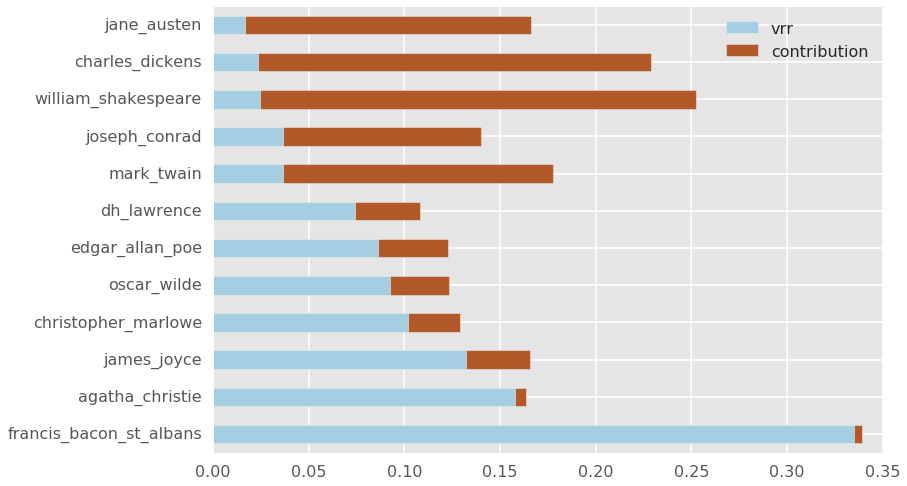

In [406]:
plt.figure()
#Plot VRR and Contribution 
ax = df_vrr_contribution.plot(kind='barh',stacked=True,figsize=(12,8),colormap='Paired')
c=ax.set_yticklabels(df_vrr_contribution.author)

This graph shows somethig unexpected. The bars that have a lot more red and only a small proportion of blue (such as Jane Austen) mean that the corpus contains a lot of text from that particular author but there is a lot of repitition in usage of words. This could either mean that there is a lot of noisy data in the document or repitition of words.

#### 2.9.3 Word Frequency Distribution 

In [407]:
#Remove  punctuations and compute word frequency
#Compute Vocabulary
def get_author_vocabulary(key):
    """
    Find vocabulary of each author 
    :param key: An s3 key path string.
    :return: A tuple (author, vocabulary list)  
    """
    s_key = str(key)
    s_key = s_key[s_key.find('/')+1:-5]
    contents = key.get_contents_as_string()
    vocab_richness_ratio = 0.0
    if contents is not None:
        contents = unicode(contents, 'utf-8')
        prog = re.compile('[\t\n\r\f\v\d\']',re.UNICODE)
        contents = re.sub(prog,' ',contents).lower()
        #Remove punctuations
        prog=re.compile('[!\"#$%&\'()*+\,-./:;<=>?@[\]^_`{|}~]',re.UNICODE)
        contents = re.sub(prog,' ',contents)
        words = word_tokenize(contents)
        vocab = []
        #Remove noisy single alphabets
        for word in words:
            word=word.strip()
            if len(word)>1:
                if word not in stopwords_:
                    vocab.append(wordnet_lemmatizer_.lemmatize(word))
        
    return (s_key,vocab)

author_vocabulary = sc.parallelize(corpus_keys).map(get_author_vocabulary).collect()

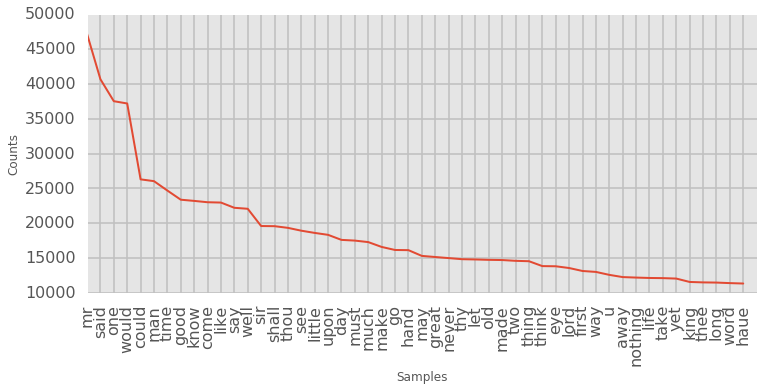

In [408]:
#Compute and Plot frequency distribution
n_tuples = len(author_vocabulary)
authors_index = range(n_tuples)
all_words = []
for i in authors_index:
    all_words = all_words + author_vocabulary[i][1]
f, axarr = plt.subplots(1, figsize=(12, 5))
fdist = nl.FreqDist(all_words)

fdist.plot(50,cumulative=False)

The distribution almost resembles Zipf's distribution(as expected).

### 3. Model Planning

There are many diverse approaches employed by different researchers in authorship attribution, however in this project I decided to only use Bag of Words approach based on the assumption that every author has certain favourite words that he/she repeats in his/her written work.

I also decided to give preference to Scikit Learn Toolkit for different machine learning algorithms as it offered more learning algorithms choice than offered by MLLib.


#### 3.1 Utility Functions for Classification

These functions are adapted from function used in lab 6 of CS109. Copyrights reserved with Harvard Extension school staff.

In [457]:
#Generic utility function to perforn K-Fold cross validation 
# to find optimal parameters for a given classifier
def cv_optimize(clf, parameters, X, y, n_jobs=1, n_folds=5, score_func=None):
    if score_func:
        gs = GridSearchCV(clf, param_grid=parameters, cv=n_folds, n_jobs=n_jobs, scoring=score_func)
    else:
        gs = GridSearchCV(clf, param_grid=parameters, n_jobs=n_jobs, cv=n_folds)
    gs.fit(X, y)
    print "Best Parameters:", gs.best_params_, gs.best_score_, gs.grid_scores_
    best = gs.best_estimator_
    return best

#Generic utility function to classify given classifier, its parameters and features
def do_classify(clf, parameters, x_train, y_train,x_test,y_test, score_func=None, n_folds=5, n_jobs=1):
    if parameters:
        clf = cv_optimize(clf, parameters, x_train, y_train, n_jobs=n_jobs, n_folds=n_folds, score_func=score_func)
    clf=clf.fit(x_train, y_train)
    training_accuracy = clf.score(x_train, y_train)
    test_accuracy = clf.score(x_test, y_test)
    
    print "Accuracy on training data: %0.2f" % (training_accuracy)
    print "Accuracy on test data:     %0.2f" % (test_accuracy)
    #print confusion_matrix(y_test, clf.predict(x_test))#
    return clf,x_train,x_test,y_train,y_test


cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])
cm = plt.cm.RdBu
cm_bright = ListedColormap(['#FF0000', '#0000FF'])



#### 3.2 Vocabulary Creation 

The first step is to build our vocabulary by using all unique words from the corpus

In [410]:
# Save Corpus and Compute Vocabulary
def get_author_vocabulary_pair(key):
    """
    Find vocabulary of each author 
    :param key: An s3 key path string.
    :return: A tuple (author, vocabulary list)  
    """
    s_key = str(key)
    s_key = s_key[s_key.find('/')+1:-5]
    contents = key.get_contents_as_string()
    vocab_richness_ratio = 0.0
    if contents is not None:
        contents = unicode(contents, 'utf-8')
        prog = re.compile('[\t\n\r\f\v\d\']',re.UNICODE)
        contents = re.sub(prog,' ',contents).lower()
        #Remove punctuations
        prog=re.compile('[!\"#$%&\'()*+\,-./:;<=>?@[\]^_`{|}~]',re.UNICODE)
        contents = re.sub(prog,' ',contents)
        words = word_tokenize(contents)
        #Remove stop words
        vocab = []
        for word in words:
            word=word.strip()
            if len(word)>1:
                if word not in stopwords_:
                    vocab.append(wordnet_lemmatizer_.lemmatize(word))
        unique_vocab = list(set(vocab))        
    return (s_key,unique_vocab)

#Compute vocabulary text document without removing
#unique words 
def get_author_document_pair(key):
    """
    Return cleaned document of each author 
    :param key: An s3 key path string.
    :return: A tuple (author, vocabulary list)  
    """
    s_key = str(key)
    s_key = s_key[s_key.find('/')+1:-5]
    contents = key.get_contents_as_string()
    if contents is not None:
        contents = unicode(contents, 'utf-8')
        prog = re.compile('[\t\n\r\f\v\d\']',re.UNICODE)
        contents = re.sub(prog,' ',contents).lower()
        #Remove punctuations
        prog=re.compile('[!\"#$%&\'()*+\,-./:;<=>?@[\]^_`{|}~]',re.UNICODE)
        contents = re.sub(prog,' ',contents)
        words = word_tokenize(contents)
        #Remove stop words and punctuations
        vocab = []
        for word in words:
            word=word.strip()
            if len(word)>1:
                if word not in stopwords_:
                    vocab.append(wordnet_lemmatizer_.lemmatize(word))
        document = ' '.join(w for w in vocab)        
    return (s_key,document)


#Save corpus in S3 as JSON
corpus_rdd = sc.parallelize(corpus_keys).map(get_author_document_pair) 

corpus_rdd.map(lambda x: json.dumps({"author":x[0],"vocabulary":x[1]})) \
    .saveAsTextFile('s3://'+S3_BUCKET_NAME+'/acorpus.json')

#Find unique words by each author
vocab_rdd = sc.parallelize(corpus_keys).map(get_author_vocabulary_pair)
vocabulary = vocab_rdd.collect()


In [411]:
#Size of vocabulary for each author
n_tuples = len(vocabulary)
authors_index = range(n_tuples)
author_vocabularysize_pairs = [(vocabulary[i][0],len(vocabulary[i][1])) for i in authors_index]
df_author_vocabularysize_pairs=pd.DataFrame(author_vocabularysize_pairs,columns=['author','vocabulary_size'] )
df_author_vocabularysize_pairs=df_author_vocabularysize_pairs.sort_values('vocabulary_size',ascending=False)
print df_author_vocabularysize_pairs

                     author  vocabulary_size
1       william_shakespeare            38092
4                mark_twain            31478
0           charles_dickens            29573
3               james_joyce            29286
9             joseph_conrad            23010
6           edgar_allan_poe            18543
5               oscar_wilde            17420
8       christopher_marlowe            17154
11              dh_lawrence            15742
2               jane_austen            14266
10          agatha_christie             5961
7   francis_bacon_st_albans             5512


Now we need to combine all these individual vocabularies into corpus vocabulary

In [412]:
#Combine all individual vocabularies
corpus_all_words = []
for i in authors_index:
    corpus_all_words = corpus_all_words + vocabulary[i][1]
vocabulary_ = list(set(corpus_all_words))

print "Corpus Vocabulary Size:"+str(len(vocabulary_))+" words"


Corpus Vocabulary Size:93085 words


It is important to mention that these words may contain Nouns that we can remove by POS tagging BUT in authorship attribution our assumption is that some authors may have favourite character names.

In [413]:
#Create vocabulary RDD
vocabrdd = sc.parallelize([word for word in vocabulary_]).map(lambda l: l)
#Create vocabulary tuple
vocabtups = (vocabrdd.map(lambda word: (word, 1))
             .reduceByKey(lambda a, b: a + b)
             .map(lambda (x,y): x)
             .zipWithIndex()
).cache()
vocab = vocabtups.collectAsMap()

This vocabulary will be passed to CountVectorizer

#### 3.3 Feature Selection

Careful Feature Selection is imperative for building good machine learning models. From the same datasets one may select different features for different problems. For sentiment analysis, adjectives are selected as features and punctuations may not be critical but an authorship attribution task may use syntactic features of a document. In this stage we can employ dimensionality reduction to reduce the feature space.

In this project, I have used "Bag of Words" approach. As the name implies, bag of words approach represents text of a document as a set of terms and does not give any significance to context or order.

In [415]:
#Take Samples from Corpus
S3_BUCKET_NAME='cs109-gutenberg'

#Function to get feature samples
def get_features_sample(author_document):
    author_label = author_document[0]
    document = author_document[1]
    complete_sample =[]
    sample_size = 200
    num_of_samples = 20
    index = range(num_of_samples)
    words = word_tokenize(document)
    for i in index:
        sample = np.random.choice(words,sample_size,replace=False)
        complete_sample.append(sample)
    author_sample = {}
    author_sample[author_label] = complete_sample
    return (author_label,author_sample)
    
#Read vocabulary from S3 as dataframe
vocab_df = sqlContext.read.json('s3://'+S3_BUCKET_NAME+'/acorpus.json')

#Take as many samples as minimum from each vocabulary
# Sampling may not be required for clusters with EC2 instances with better
# CPU and Memory resources
sampled_vocab_rdd = vocab_df.map(lambda x:get_features_sample(x))



In [416]:
#Create a dictionary with 
#every sample matched with label

def create_author_sample_dictionary(feature_sample):
    author_label = feature_sample[0]
    document_dictionary = feature_sample[1]
    dictionary_keys = document_dictionary.keys()
    sample_dictionary_list=[]
    sample_dictionary = {}
    for key in dictionary_keys:
        document_array = document_dictionary.get(key)
        for samples in document_array:
            sample_dictionary = {}
            sample_dictionary[key] = samples.tolist()
            sample_dictionary_list.append(sample_dictionary)
    return (author_label,sample_dictionary_list)

author_sample_rdd = sampled_vocab_rdd.map(lambda x:create_author_sample_dictionary(x))
sample_dictionary = author_sample_rdd.flatMap(lambda x:x[1]).collect()


In [417]:

#Create Data Frame for feature sets
data =[]
for dictionary in sample_dictionary:
    keys = dictionary.keys()
    values_array = dictionary.get(keys[0])
    author_data_pair =[]
    author_data_pair.append(keys[0])
    author_data_pair.append(' '.join(w for w in values_array))
    data.append(author_data_pair)
    
df_features = pd.DataFrame(data, columns=['author','sample'])

#Convert author names to numerical values
author_name_value_dict = {}
for i,author in enumerate(famous_authors):
    author_name_value_dict[author]=i

df_features['author'] = df_features['author'].map(author_name_value_dict)

#### 3.3 Feature Extraction 

Feature Extraction Process involves converting textual data to numerical feature vectors that can be used as input to machine learning algorithms. I have mainly used CountVectorizer for feature extraction.

In [514]:
#Extract Vector Features
vectorizer = CountVectorizer(vocabulary=vocab)

#Create x,y i.e features, responses
vectorized_features = vectorizer.fit_transform(df_features['sample'])
X = vectorized_features
y = df_features['author'].values


### 4. Model Building

In this phase I converted the feature set to training and testing portions and used following approach to model building.

1) Select a machine learning algorithm

2) Conduct KFold Cross Validation for finding optimal parameters

3) Fit the model on training data with optimal parameters

4) Test the model on testing data

5) Compute Accuracy


Repeat the steps for each model.

#### 4.1 Training Testing Split 

In [515]:
xtrain, xtest, ytrain, ytest = train_test_split(X,y)

#### 4.2 K Nearest Neighbors (KNN) Classifier 

KNN is a non-parametric classification algorithm. It does not make any assumption about the distribution of the underlying data and is very fast. It takes majority voting of K neighbors to decide class the feature belongs to.

In [516]:
from sklearn.neighbors import KNeighborsClassifier
clf = KNeighborsClassifier()
parameters = {"n_neighbors":[2,4,6,8]}
model = do_classify(clf,parameters,xtrain,ytrain,xtest,ytest)


Best Parameters: {'n_neighbors': 8} 0.844444444444 [mean: 0.72222, std: 0.07499, params: {'n_neighbors': 2}, mean: 0.78333, std: 0.06708, params: {'n_neighbors': 4}, mean: 0.80000, std: 0.07095, params: {'n_neighbors': 6}, mean: 0.84444, std: 0.08441, params: {'n_neighbors': 8}]
Accuracy on training data: 0.91
Accuracy on test data:     0.83


#### 4.3  Support Vector Machines

Support Vector Machines (SVM) is an extension of Support Vector Classifier. It classifies features by using separating hyperplanes.

In [517]:
from sklearn.svm import LinearSVC
clf_linearSVC = LinearSVC()
parameters = {"C": [0.001, 0.01, 0.1, 1, 10, 100, 1000]}
model = do_classify(clf_linearSVC,parameters,xtrain,ytrain,xtest,ytest)


Best Parameters: {'C': 0.1} 0.961111111111 [mean: 0.92778, std: 0.03854, params: {'C': 0.001}, mean: 0.95000, std: 0.01845, params: {'C': 0.01}, mean: 0.96111, std: 0.01185, params: {'C': 0.1}, mean: 0.96111, std: 0.01185, params: {'C': 1}, mean: 0.96111, std: 0.01185, params: {'C': 10}, mean: 0.96111, std: 0.01185, params: {'C': 100}, mean: 0.96111, std: 0.01185, params: {'C': 1000}]
Accuracy on training data: 1.00
Accuracy on test data:     0.98


#### 4.4 Naive Bayes 

Naive Bayes is a probablistic classification method based on Baye's theorem. A naive Bayes classifier assumes that absence or presence of a feature of a class is not related to the absence or presence of other features. This is also called conditional independence.
Mathematicall this can be written as :

$$P(c|d) \propto P(d|c) P(c) $$

$$P(d|c)  = \prod_k P(t_k | c) $$


Where _c_ is class, _d_ denotes document and _t_k_ is the kth term. This therefore means that the probability that it is class _c_ given document _d_ is proportional to the product of prior probability of the class and probability of document being _d_ if the class is _c_.


In [513]:
clf = MultinomialNB()
parameters = {"alpha": [0.01, 0.1, 0.5, 1]}
result = do_classify(clf,parameters,xtrain,ytrain,xtest,ytest)

Best Parameters: {'alpha': 0.01} 0.95 [mean: 0.95000, std: 0.01758, params: {'alpha': 0.01}, mean: 0.85000, std: 0.05717, params: {'alpha': 0.1}, mean: 0.55556, std: 0.05134, params: {'alpha': 0.5}, mean: 0.40556, std: 0.04886, params: {'alpha': 1}]
Accuracy on training data: 1.00
Accuracy on test data:     0.95


#### 4.5 Random Forest  

Random Forest is an ensemble method that fits a number of decision tree classifiers on various subsamples of the dataset and use averaging to improve the predictive accuracy and control over-fitting.

In [486]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier()
parameters = {"n_estimators": [10, 20, 30, 40]}
result = do_classify(clf,parameters,xtrain,ytrain,xtest,ytest)


Best Parameters: {'n_estimators': 40} 0.666666666667 [mean: 0.43333, std: 0.04683, params: {'n_estimators': 10}, mean: 0.56111, std: 0.03237, params: {'n_estimators': 20}, mean: 0.59444, std: 0.05399, params: {'n_estimators': 30}, mean: 0.66667, std: 0.08489, params: {'n_estimators': 40}]
Accuracy on training data: 1.00
Accuracy on test data:     0.60


#### 4.6 Final Analysis of Multiclass classification

Looking at the accuracy results, Multinomial Naive Bayesian and SVM have given the maximum prediction accuracy on testing data. We shall use Naive Bayesian for operational implementation.



In [487]:
#Get Confusion matrix
clf = MultinomialNB(alpha=0.01)
clf.fit(xtrain,ytrain)
training_accuracy = clf.score(xtrain, ytrain)
test_accuracy = clf.score(xtest, ytest)
print confusion_matrix(ytest,clf.predict(xtest))
print "Accuracy on training data: %0.2f" % (training_accuracy)
print "Accuracy on test data:     %0.2f" % (test_accuracy)



[[3 0 0 0 0 0 0 0 0 0 0 0]
 [0 7 0 0 0 0 0 0 0 0 0 0]
 [0 0 2 0 0 0 0 0 0 0 0 0]
 [2 0 0 5 1 0 0 0 0 0 0 2]
 [0 0 0 0 5 0 0 0 0 3 0 0]
 [0 0 0 0 0 3 0 0 0 0 0 0]
 [0 0 0 0 0 0 6 0 0 0 0 0]
 [0 0 0 0 0 0 0 7 0 0 0 0]
 [0 0 0 0 0 0 0 0 5 0 0 0]
 [0 0 0 0 0 0 0 0 0 2 0 0]
 [0 0 0 0 0 0 0 0 0 0 2 0]
 [0 0 0 0 0 0 0 0 0 0 0 5]]
Accuracy on training data: 1.00
Accuracy on test data:     0.87


In [489]:
#Print Classification Report
print classification_report(ytest,clf.predict(xtest))

             precision    recall  f1-score   support

          0       0.60      1.00      0.75         3
          1       1.00      1.00      1.00         7
          2       1.00      1.00      1.00         2
          3       1.00      0.50      0.67        10
          4       0.83      0.62      0.71         8
          5       1.00      1.00      1.00         3
          6       1.00      1.00      1.00         6
          7       1.00      1.00      1.00         7
          8       1.00      1.00      1.00         5
          9       0.40      1.00      0.57         2
         10       1.00      1.00      1.00         2
         11       0.71      1.00      0.83         5

avg / total       0.91      0.87      0.87        60



### 5. Results

The results of the project can be summarized as responses to the following questions.

1) Can "Bag of Words" as features give acceptable classification accuracy?
All classifiers have given good accuracies making it a suitable technique for Authorship attribution.

2) Which algorithms perform best with Bag of Words?
SVM and Naive Bayes have performed best for Bag of Words based authorship attribution.

3) How can Big Data processing engines such as Apache Spark aid in preparing data for Machine Learning algorithms?
Spark was used through out this project and managed to clean 12G of raw gutenberg data in matter of minutes.

4) How can one clean Gutenberg data to be used for different NLP related research projects?
Cleaning Gutenberg data took a long time. NLTK provides a subset of Gutenberg corpus but it would be interesting to scale up authorship attribution for the full set of authors using complete Gutenberg data.

5) Can AWS EMR be used as a viable cloud based Big Data platform?
I have found AWS EMR to be very convenient. EMR clusters with m3.xlarge with 3 nodes are more than enough for most operations but the cleaning stage required 5 EC2 nodes of m3.xlarge. 

### 6. Operational Implementation 

In this phase the model should be saved and used via command line.


#### 6.1 Saving the model 

In [495]:
#We can save the model as pickel file
from sklearn.externals import joblib
clf_linearSVC = LinearSVC(C=0.01)
clf_linearSVC.fit(xtrain,ytrain)
joblib.dump(clf_linearSVC, './data/svm.pkl')
joblib.dump(clf, './data/classifier.pkl')
joblib.dump(vectorizer,'./data/vectorizer.pkl')


['./data/vectorizer.pkl']

#### 6.2 Script to Load Text File and Give Result 

In [ ]:
#This code is given in the scripts folder and should be run on 
#via command line
#!/usr/bin/env python
# This script can be used to detect author's name from sample of his/her works
from sklearn.externals import joblib
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import re
import sys

#Model file path
model_file = '../data/classifier.pkl'
vectorizer_file = '../data/vectorizer.pkl'
# The machine learning model used in this case is only trained with the following authors.
famous_authors = ['charles_dickens','william_shakespeare','jane_austen','james_joyce','mark_twain','oscar_wilde','edgar_allan_poe',
                  'francis_bacon_st_albans','christopher_marlowe','joseph_conrad','agatha_christie','dh_lawrence']
#Function : print_help
#Purpose : Function to display help message
def print_help():
    print "Usage :"+sys.argv[0]+" <path to sample text file>"
    print " Where sample text file contains text by one of authors given above"
#Function : get_author_text
#Purpose : Convert raw text document to tokens
def get_author_text(sample_file):
     try:

        with open(sample_file,'r') as file:
            data = file.read()
     except IOError as e:
        print "I/O Error".format(e.errno, e.strerror)
        sys.exit(2)

     #Set language for stopwords
     stopwords_ = stopwords.words('english')
     #Instantiate Lemmatizer
     wordnet_lemmatizer_ = WordNetLemmatizer()
     #Clean the sample data
     contents = unicode(data, 'utf-8')
     prog = re.compile('[\t\n\r\f\v\d\']',re.UNICODE)
     contents = re.sub(prog,' ',contents).lower()
     #Remove punctuations
     prog=re.compile('[!\"#$%&\'()*+\,-./:;<=>?@[\]^_`{|}~]',re.UNICODE)
     contents = re.sub(prog,' ',contents)
     words = word_tokenize(contents)
     #Remove stop words and punctuations
     vocab = []
     for word in words:
         word=word.strip()
         if len(word)>1:
             if word not in stopwords_:
                 vocab.append(wordnet_lemmatizer_.lemmatize(word))
     return vocab

#Check input arguments
if (len(sys.argv) < 2):
    print_help()
    sys.exit(1)

text = get_author_text(sys.argv[1])
clf = joblib.load(model_file)
svm = joblib.load('../data/svm.pkl')
vectorizer = joblib.load(vectorizer_file)
features = vectorizer.transform(text)
nb_prediction= clf.predict(features).tolist()
svm_prediction = svm.predict(features).tolist()
print nb_prediction
print svm_prediction


## References

[1]. Stańczyk, U & Krzysztof, AC 2007, 'Machine learning approach to authorship attribution of literary texts', vol. 1, no. 4, pp. 151-158.

[2]. Bozkurt, D., Baglıoglu, O., & Uyar, E. 2007, 'Authorship Attribution: Performance of Various Features and Classification Methods' Computer and Information Sciences.

[3]. Pratanwanich, N & Lio, P 2014, 'Who Wrote This? Textual Modeling with Authorship Attribution in Big Data',Proceedings of the ￼2014 IEEE International Conference on Data Mining Workshop , pp 645-652.

_Online Resources_:

https://en.wikipedia.org/wiki/Stylometry

http://michaelryanbell.com/processing-whole-files-spark-s3.html 

http://help.mortardata.com/technologies/spark/train_a_machine_learning_model
